## U-NET Model With Data Augmentation and Extensive Tuning

### U-NET Architecture

The U-Net model is designed for efficient image segmentation, particularly in medical imaging and other pixel-level tasks. Key functionality of the U-Net model includes:

Encoder: This part extracts high-level semantic features from the input image. It typically involves convolutional layers followed by max-pooling operations that progressively reduce the spatial dimensions of the input, while increasing the depth of feature maps.

Bottleneck: The lowest part of the U-Net where the spatial dimensions are smallest. This section captures the most abstract features of the image, containing the encoded information for the segmentation task.

Decoder: The decoder restores the spatial resolution of the feature maps to match the original image size. It uses upsampling or transposed convolutional layers to expand the feature maps, converting the encoded features back into a segmentation mask.

Skip Connections: The hallmark of U-Net, skip connections directly link corresponding layers in the encoder and decoder. These connections help retain fine-grained details lost during downsampling, allowing the decoder to produce more precise segmentations, especially for boundaries and small structures.

This architecture is highly effective because it balances the need for abstract feature extraction (through the encoder) and fine-grained spatial detail recovery (through the decoder and skip connections).

### Download Data

In [ ]:

!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351' -O images.zip


--2024-11-08 16:39:23--  https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.46.225, 2607:f8b0:4005:813::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.46.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748584920 (714M) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 713.91M  22.8MB/s    in 33s     

2024-11-08 16:39:58 (21.8 MB/s) - ‘images.zip’ saved [748584920/748584920]



In [2]:
!unzip images.zip

Archive:  images.zip
  inflating: kaggle_3m/README.md     
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif  
  inf

### Data Preprocessing

In [1]:
IMAGE_PATH = 'lgg-mri-segmentation/kaggle_3m'

In [2]:
## source: https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
import os
paths = []

for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):

        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]

(7858,
 ['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'])

In [3]:
## source https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})

    # Dividing the indexes into train, test, and validation
    train_index, test_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.15, random_state=42)
    train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]

    return train_df, val_df, test_df

# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

3005 334 590


ID  \
472   TCGA_DU_6408_19860521_31   
288   TCGA_DU_6405_19851005_23   
3666  TCGA_FG_6691_20020405_29   
851   TCGA_DU_7018_19911220_36   
2796  TCGA_HT_A61B_19991127_11   

                                                  Image  \
472   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...   
288   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...   
3666  lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...   
851   lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...   
2796  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...   

                                                   Mask  Diagnosis  
472   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...          1  
288   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...          0  
3666  lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...          1  
851   lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...          0  
2796  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...          0

### Visualizing

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

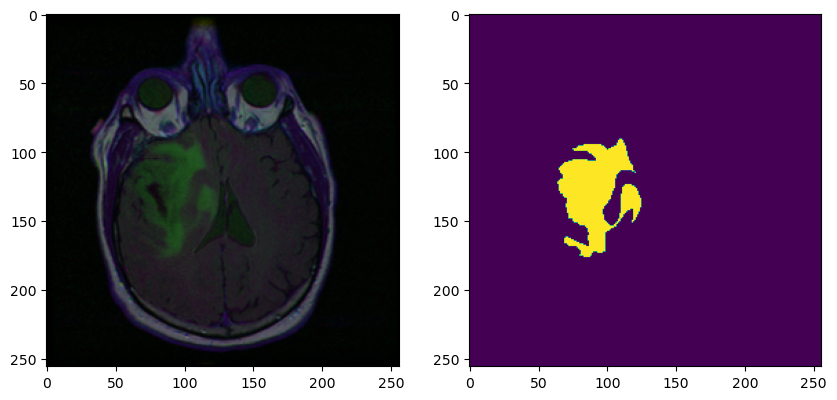

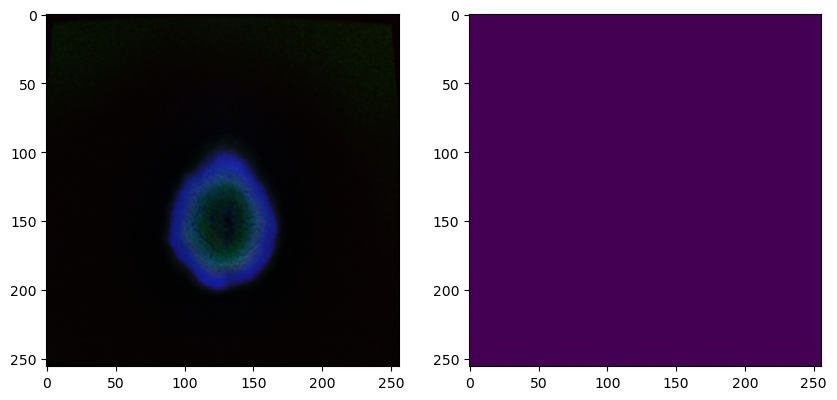

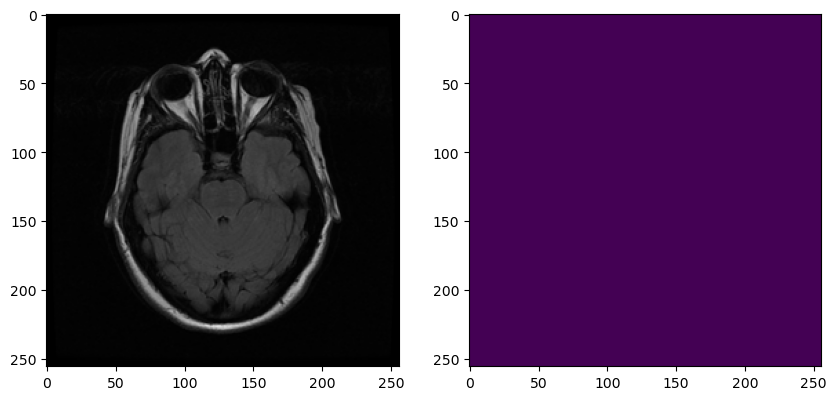

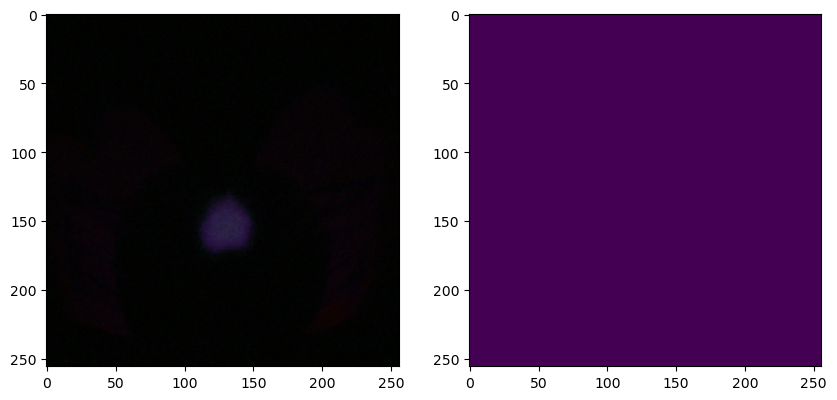

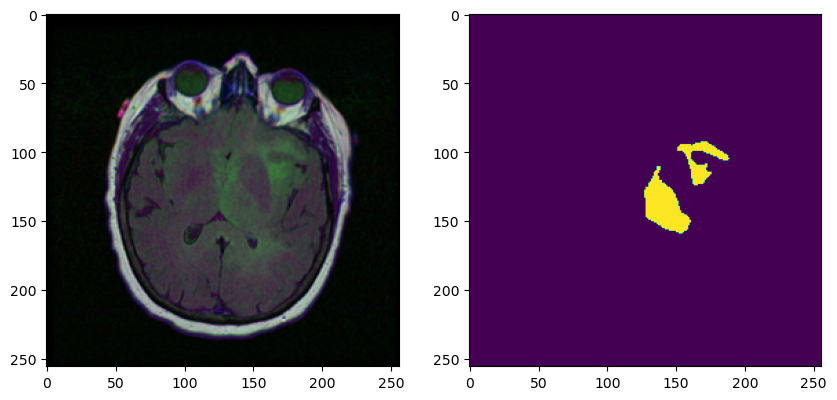

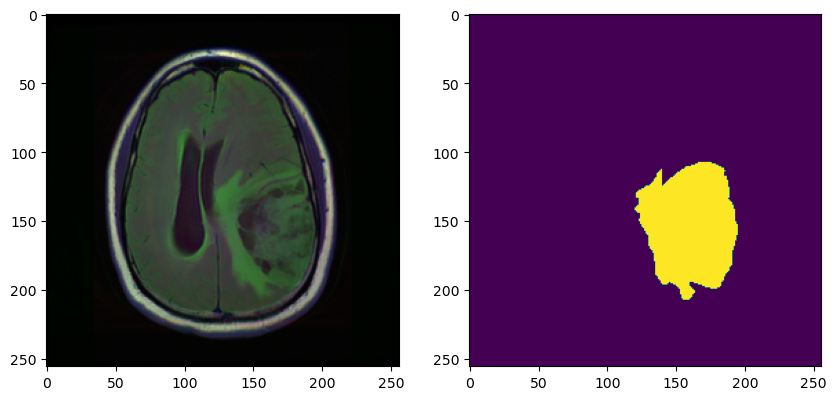

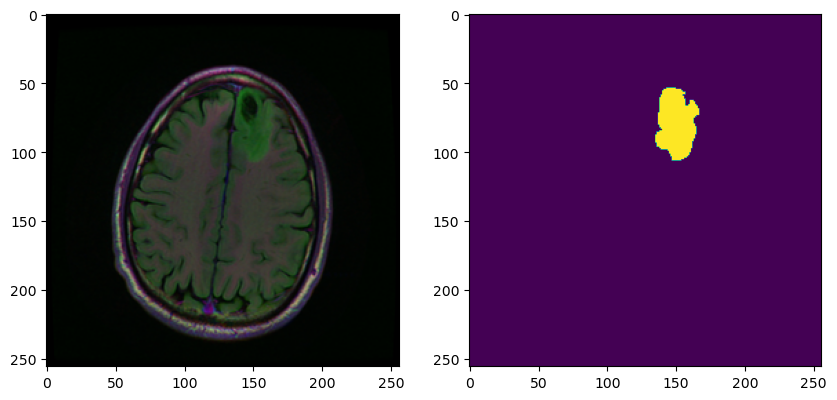

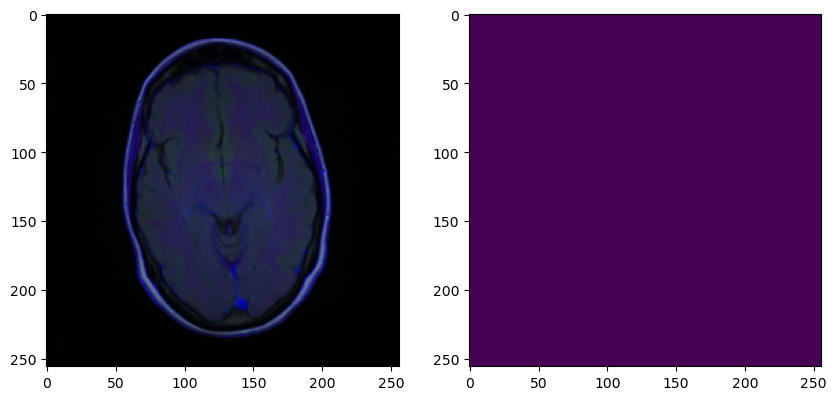

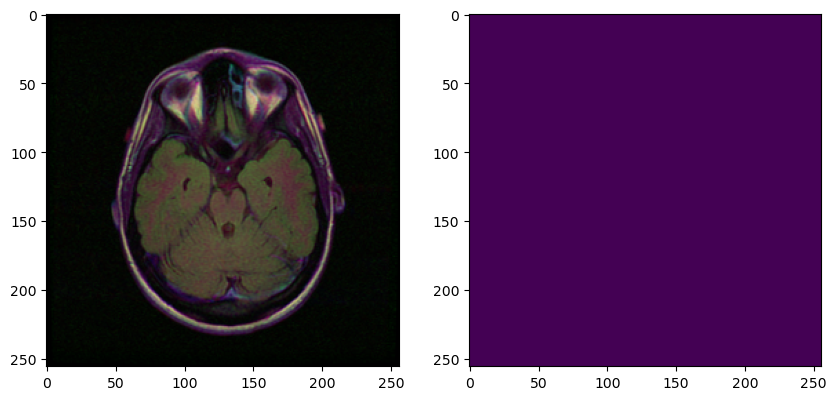

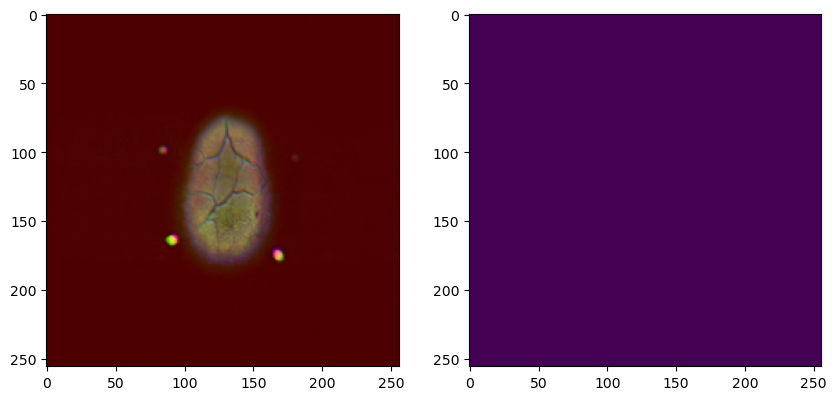

In [19]:
index = np.arange(train_df.shape[0])
rng = np.random.default_rng(37)
rng.shuffle(index)
for idx in range(10):
    image_path = train_df.iloc[index[idx]]['Image']
    mask_path = train_df.iloc[index[idx]]['Mask']
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask)

### Training the Model

U-NET model with BCELoss

In [7]:
import torch

print(torch.cuda.is_available())
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 2060
1


In [4]:
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=1.0

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels,device):
        super(UNET, self).__init__()
       
        self.device = device
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
        
        # Define encoder and decoder blocks with in/out channels
        self.enc1 = self.encode_block(in_channels, 64)
        self.enc2 = self.encode_block(64, 128)
        self.enc3 = self.encode_block(128, 256)
        self.enc4 = self.encode_block(256, 512)
        self.enc5 = self.encode_block(512, 1024)
        
        self.dec4 = self.decode_block(1024, 512)
        self.dec3 = self.decode_block(512, 256)
        self.dec2 = self.decode_block(256, 128)
        self.dec1 = self.decode_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    # Encoder
    def encode_block (self, in_channels, out_channels): 
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding=1),#3x3 Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),#Non-linearity function
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding=1),  
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def up_conv(self, in_channels, out_channels):# Upsampling: Doubles spatial dimensions of feature maps, however ConvTranspose also halves the number of feature maps with 2x2 Conv here after.
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2).to(self.device)#Can be refitted inside constructor to avoid .to() but this works fine
    
    
    # Decoder
    def decode_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # Encoding path
        x = self.enc1(x)
        enc1_pooled = self.pool(x)
        #print(f"enc1 shape: {x.shape}")
        
        enc2 = self.enc2(enc1_pooled)
        enc2_pooled = self.pool(enc2)
     
        enc3 = self.enc3(enc2_pooled)
        enc3_pooled = self.pool(enc3)
        
        enc4 = self.enc4(enc3_pooled)
        '''enc4_pooled = self.pool(enc4)
        
        enc5 = self.enc5(enc4_pooled)
      
        # Decoder path with upsampling
        
        dec = self.up_conv(1024,512)(enc5) 
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.dec4(dec)'''
        
        dec = self.up_conv(512, 256)(enc4) 
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.dec3(dec)
        
        dec = self.up_conv(256, 128)(dec) 
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.dec2(dec)
   
        dec = self.up_conv(128, 64)(dec)
        dec = torch.cat((dec, x), dim=1)
        dec = self.dec1(dec)
        
        dec = self.final_conv(dec)
        dec = self.sigmoid(dec)
        #print(f"Final output after 1x1 convolution: {dec}")
        return dec
        
    
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize the model

model = UNET(3,1,device=device).float().to(device)
checkpoint_path = 'latest_checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])


NVIDIA GeForce RTX 2060
1
cuda:0


/tmp/ipykernel_1715/1042908441.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [5]:
'''# Augmentations for training set
train_transform = transforms.Compose([
   transforms.RandomApply([transforms.RandomAffine(degrees=15),  # Only rotate
    ], p=0.5),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to [-1, 1]
    transforms.ToTensor()
])

# No augmentations for validation set
val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.ToTensor()
])'''
'''from scipy.ndimage import gaussian_filter, map_coordinates
# Custom Elastic Deformation class
class RandomElasticDeformation:
    def __init__(self, alpha=10, sigma=3):
        """
        alpha: Displacement magnitude (standard deviation of Gaussian)
        sigma: Standard deviation for Gaussian filter
        """
        self.alpha = alpha
        self.sigma = sigma

    def generate_random_displacement(self, shape):
        """
        Generate random displacement field based on Gaussian distribution.
        The displacement field is of the shape (height, width, 2) for 2D images.
        """
        # Create a random displacement grid (x and y directions)
        displacement = np.zeros((shape[0], shape[1], 2), dtype=np.float32)

        # Sample displacements from Gaussian distribution
        displacement[..., 0] = gaussian_filter(np.random.rand(shape[0], shape[1]), self.sigma) * self.alpha
        displacement[..., 1] = gaussian_filter(np.random.rand(shape[0], shape[1]), self.sigma) * self.alpha

        # Apply random shifts for smooth deformations
        displacement = np.clip(displacement, -self.alpha, self.alpha)
        
        return displacement

    def apply_deformation(self, image, displacement):
        """
        Apply the generated displacement field to an image using map_coordinates.
        This deforms the image by sampling from the original image according to the displacement grid.
        """
        # Create a grid of coordinates (y, x)
        shape = image.shape
        coords = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        
        # Add the displacement vectors to the grid coordinates
        coords[0] = coords[0] + displacement[..., 0]
        coords[1] = coords[1] + displacement[..., 1]
        
        # Apply the deformation using map_coordinates
        deformed_image = map_coordinates(image, coords, order=1, mode='nearest')
        
        return deformed_image'''
'''# Define the random elastic deformation with specific parameters
elastic_deform = RandomElasticDeformation(alpha=10, sigma=3)

# Combine transformations into a single transform pipeline
combined_transform = transforms.Compose([
    elastic_deform,  # Apply random elastic deformation
    transform
])'''
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, 
    Rand2DElasticd, ToTensord,EnsureTyped,RandAffined, RandGaussianNoised,RandBiasFieldd, RandGridDistortiond
)
from monai.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)
        
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) 
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0) 

        data = {"image": img, "semantic": mask}
        if not isinstance(data["image"], torch.Tensor):
            print(f"Warning: Image is not a tensor. Type: {type(data['image'])}")
        
        if not isinstance(data["semantic"], torch.Tensor):
            print(f"Warning: Mask is not a tensor. Type: {type(data['semantic'])}")

        if self.transform:
            data = self.transform(data)  

        return data["image"], data["semantic"]


# Data augmentations for use on training images 
transform = Compose([
    RandAffined(keys=["image", "semantic"], rotate_range=(0.1, 0.1), translate_range=(10, 10), scale_range=(0.1, 0.1), prob=0.5, mode=("bilinear", "nearest")),
    Rand2DElasticd(
        keys=["image", "semantic"], 
        spacing=(10, 10), 
        magnitude_range=(0.5, 0.7),  
        prob=0.5, 
        mode=("bilinear", "nearest")
    ),
    RandGridDistortiond(keys=["image", "semantic"], num_cells=5, distort_limit=0.1, prob=0.5, mode=("bilinear", "nearest")),
    RandGaussianNoised(keys=["image"], prob=0.5, mean=0.0, std=0.1),
    RandBiasFieldd(
    keys=["image"],
    coeff_range=(0.0, 0.1), 
    prob=0.5                 
    ),
    ScaleIntensityd(keys=["image", "semantic"]),  
    EnsureTyped(keys=["image", "semantic"]),  
])
# Transforms for validation and test sets remain original
dev_transform = Compose([
    ScaleIntensityd(keys=["image", "semantic"]), 
    EnsureTyped(keys=["image", "semantic"]),
    ToTensord(keys=["image", "semantic"]),
  
])
test_transform = Compose([
    ScaleIntensityd(keys=["image", "semantic"]), 
    EnsureTyped(keys=["image", "semantic"]),
    ToTensord(keys=["image", "semantic"]),
  
])







In [ ]:
from tqdm import tqdm
CUDA_LAUNCH_BLOCKING=1
PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=1.0
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=7e-5)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
#Optimizer determines how best to alter model parameters based on loss functions.

# Training loop
def train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500, patience=7):
    model.train()
    best_dev_loss = np.inf
    early_stopping_counter = 0
    patience = patience
    print(f"NUM EPOCHS: {num_epochs}")
    # Load previous checkpoint if needed (optional)
    checkpoint_path = 'latest_checkpoint.pth'
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Resuming training from checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_dev_loss = checkpoint['best_dev_loss']
        print(f"CURRENT EPOCH FROM LAST CHECKPOINT: {checkpoint['epoch']}")
    else:
        print("CANT FIND CHECKPOINT PATH")

    # Main training loop
    for epoch in tqdm(range(start_epoch, num_epochs)):
        print(f"CURRENT EPOCH TRAINING: {epoch+1}")
        running_loss = 0.0
        for images, masks in dataloader:
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            #print(f"Images shape: {images.shape}, Mask shape: {mask.shape}")
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation loop
        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(dev_dataloader, desc='Evaluating on dev set', unit='batch'):
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                dev_loss += loss.item() * images.size(0)
                
        dev_loss = dev_loss / len(dev_dataloader.dataset)
        print(f'Dev Loss: {dev_loss:.4f}')
        scheduler.step(dev_loss)
        # Save checkpoints every 2 epochs
        if (epoch+1) % 2 == 0:
            #print("INSIDE CHECKPOINT SAVER")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dev_loss': best_dev_loss,
            }
            torch.save(checkpoint, 'latest_checkpoint.pth')

        # Save the best model based on validation loss
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                torch.save(model.state_dict(), 'final_model.pth')
                break
        # Save a checkpoint after each epoch



image_paths = train_df['Image'].values.tolist()
mask_paths = train_df['Mask'].values.tolist()

dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dev_dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=dev_transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
# Training
train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500)




/home/mikhuz/miniconda3/envs/CapstoneWSL/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NUM EPOCHS: 500
Resuming training from checkpoint...


/tmp/ipykernel_1715/2706246927.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


CURRENT EPOCH FROM LAST CHECKPOINT: 64


  0%|          | 0/436 [00:00<?, ?it/s]

CURRENT EPOCH TRAINING: 65


  0%|          | 0/436 [04:01<?, ?it/s]


KeyboardInterrupt: 

### Evaluating the performance

This section evaluates a model's segmentation performance using two common metrics: Intersection over Union (IoU) and Dice coefficient (Dice). Both metrics quantify the overlap between predicted and ground truth segmentation masks.

IoU focuses on the ratio of correctly classified pixels, while Dice emphasizes the balance between true positives and both false positives and negatives. Calculating these scores to assesses the model's segmentation accuracy.

In [8]:
#Visualizes predictions using the latest model
def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        counter = 0
        for images, masks in dataloader:
            if counter > 10:
                break
            counter += 1
      
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)

            plt.figure(figsize=(22, 12))
            for i in range(min(len(images), 3)):
                plt.subplot(3, 3, i*3 + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Mask')
               
                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Actual Mask')
            plt.subplots_adjust(hspace=0.5) 
            plt.show()

/tmp/ipykernel_1715/3565651710.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


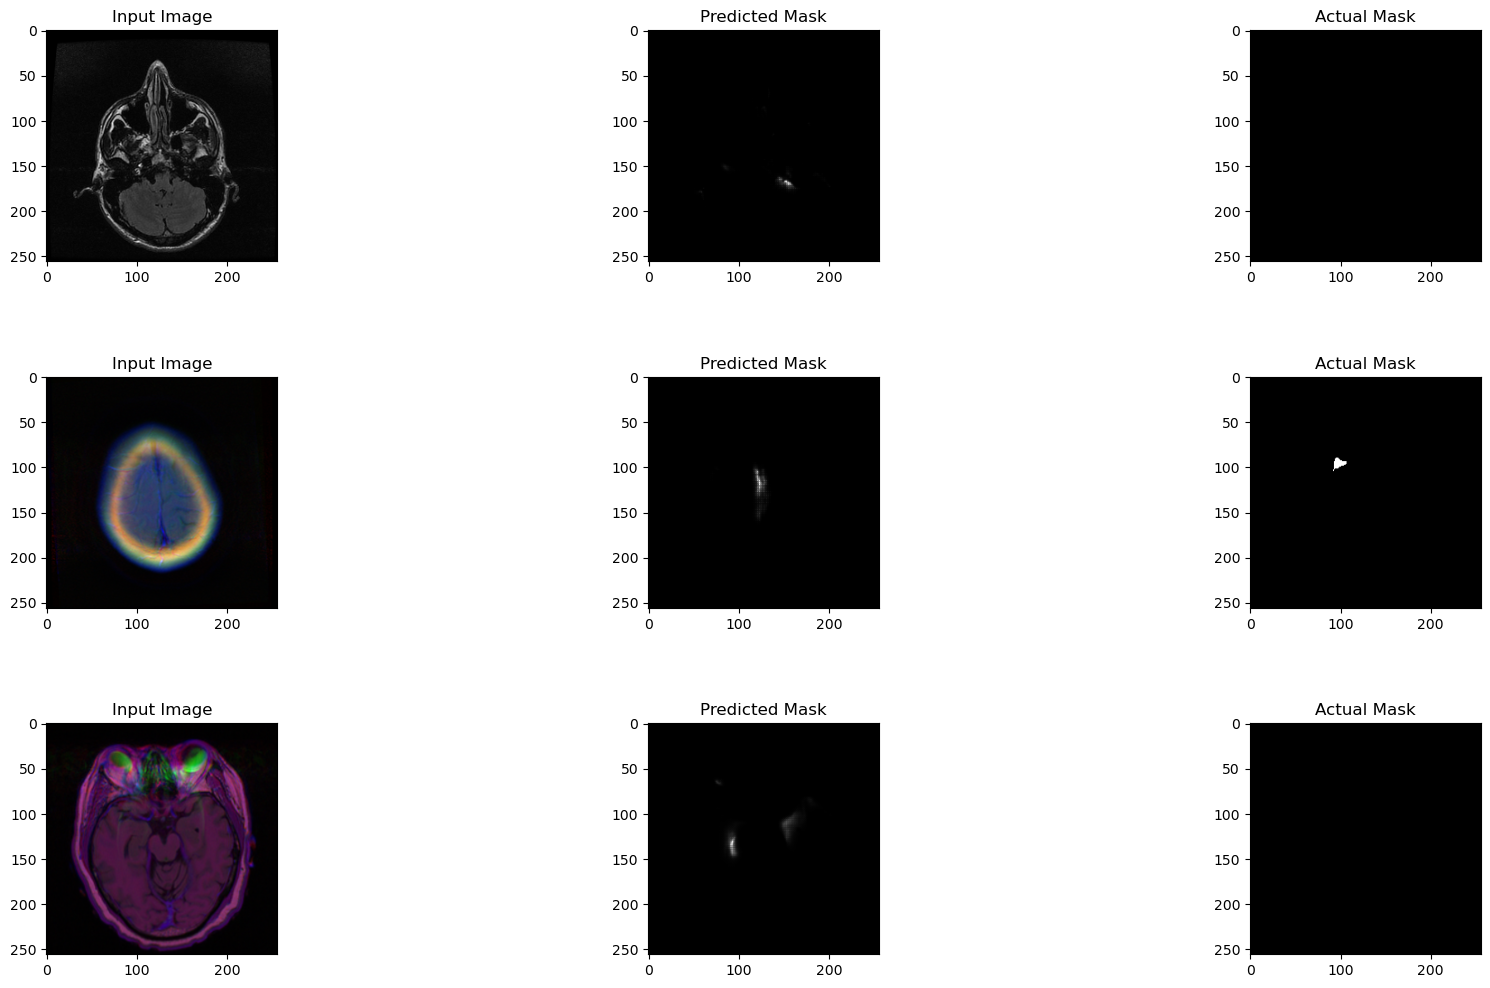

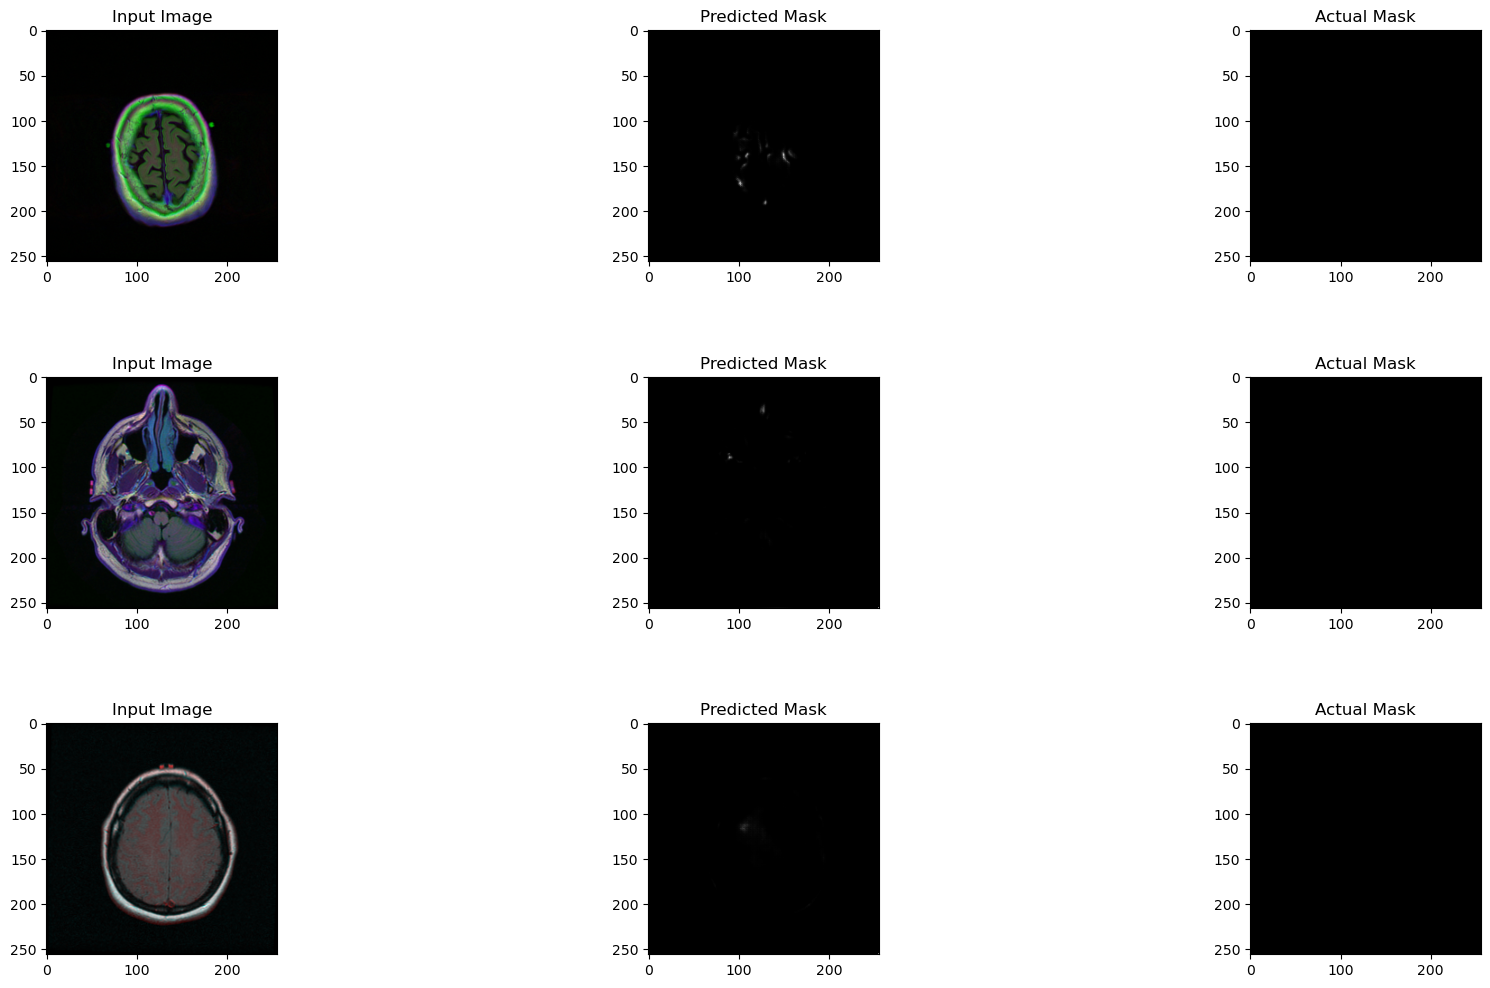

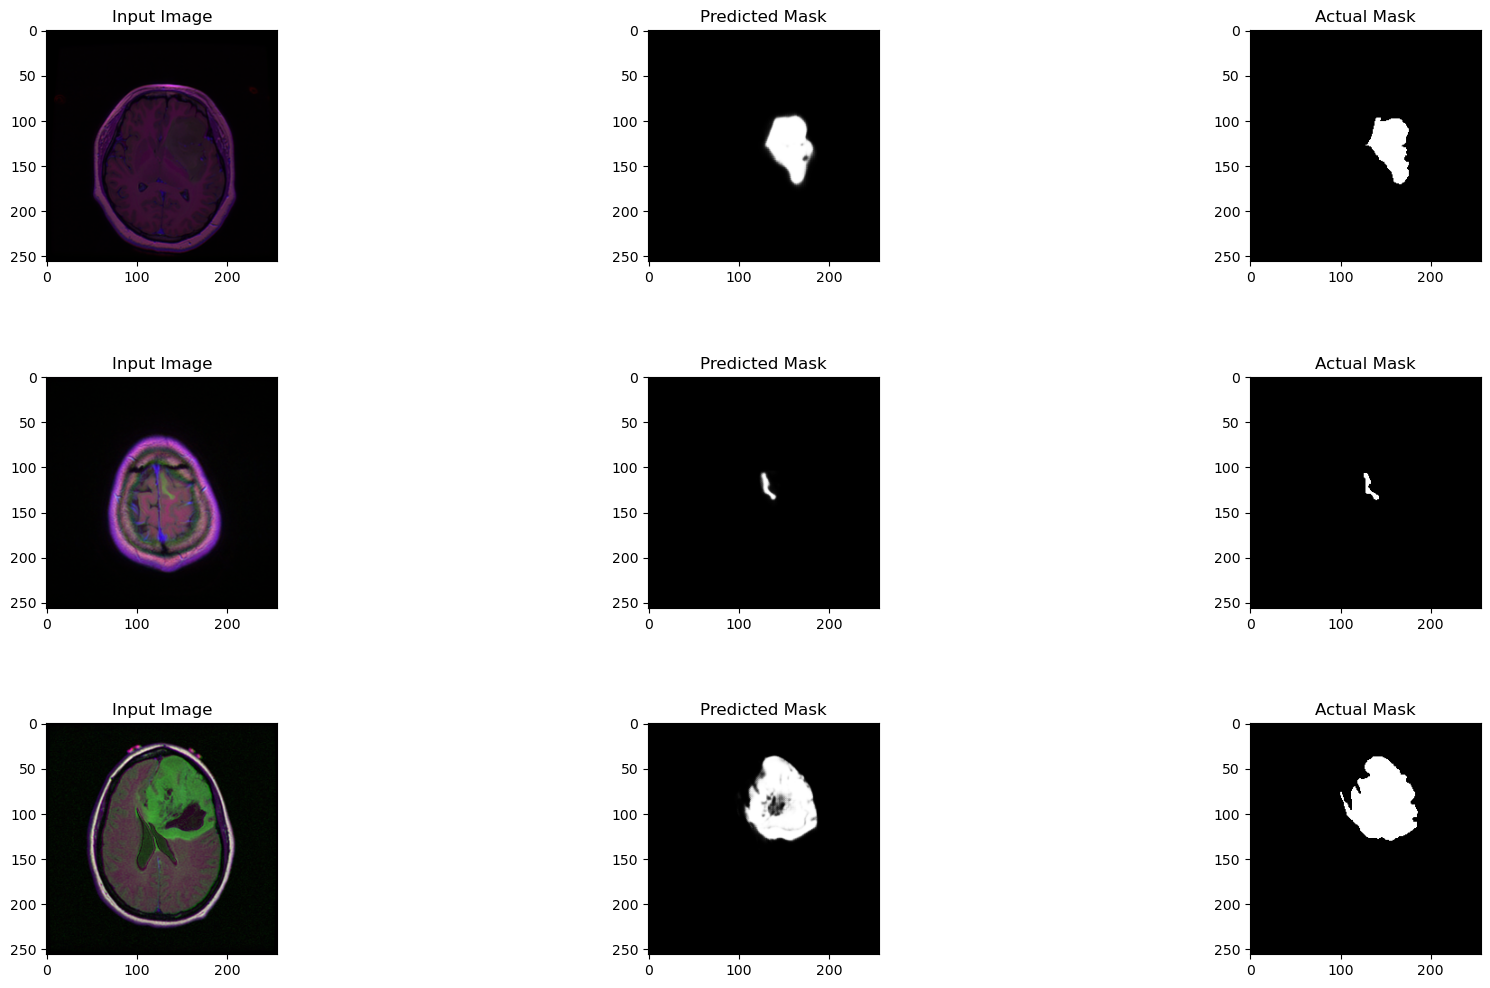

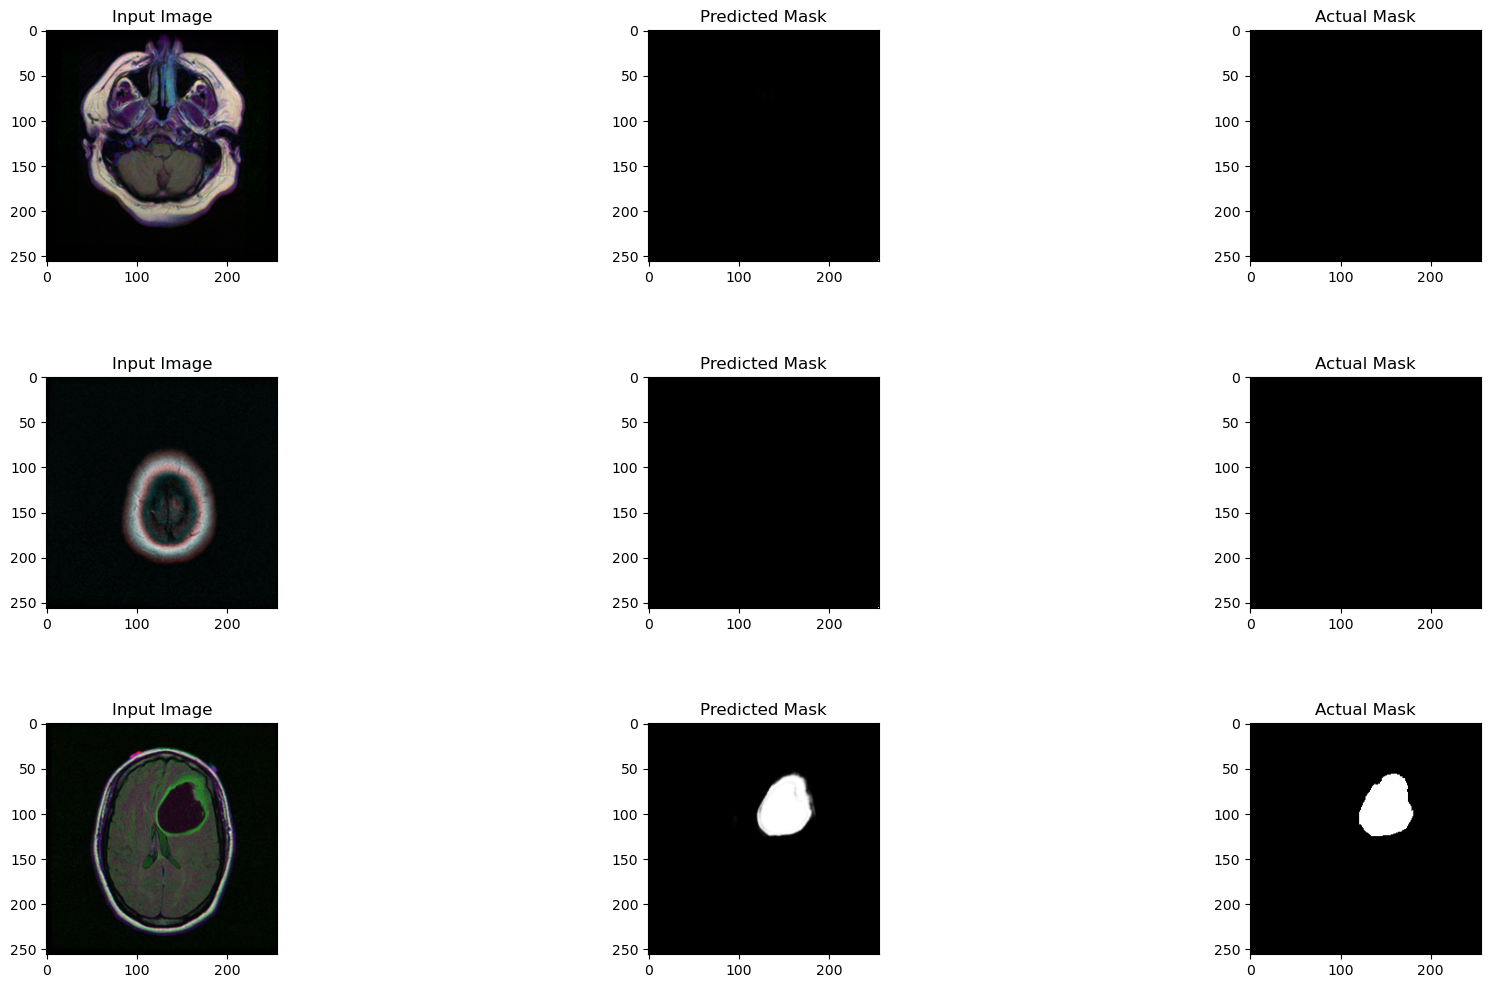

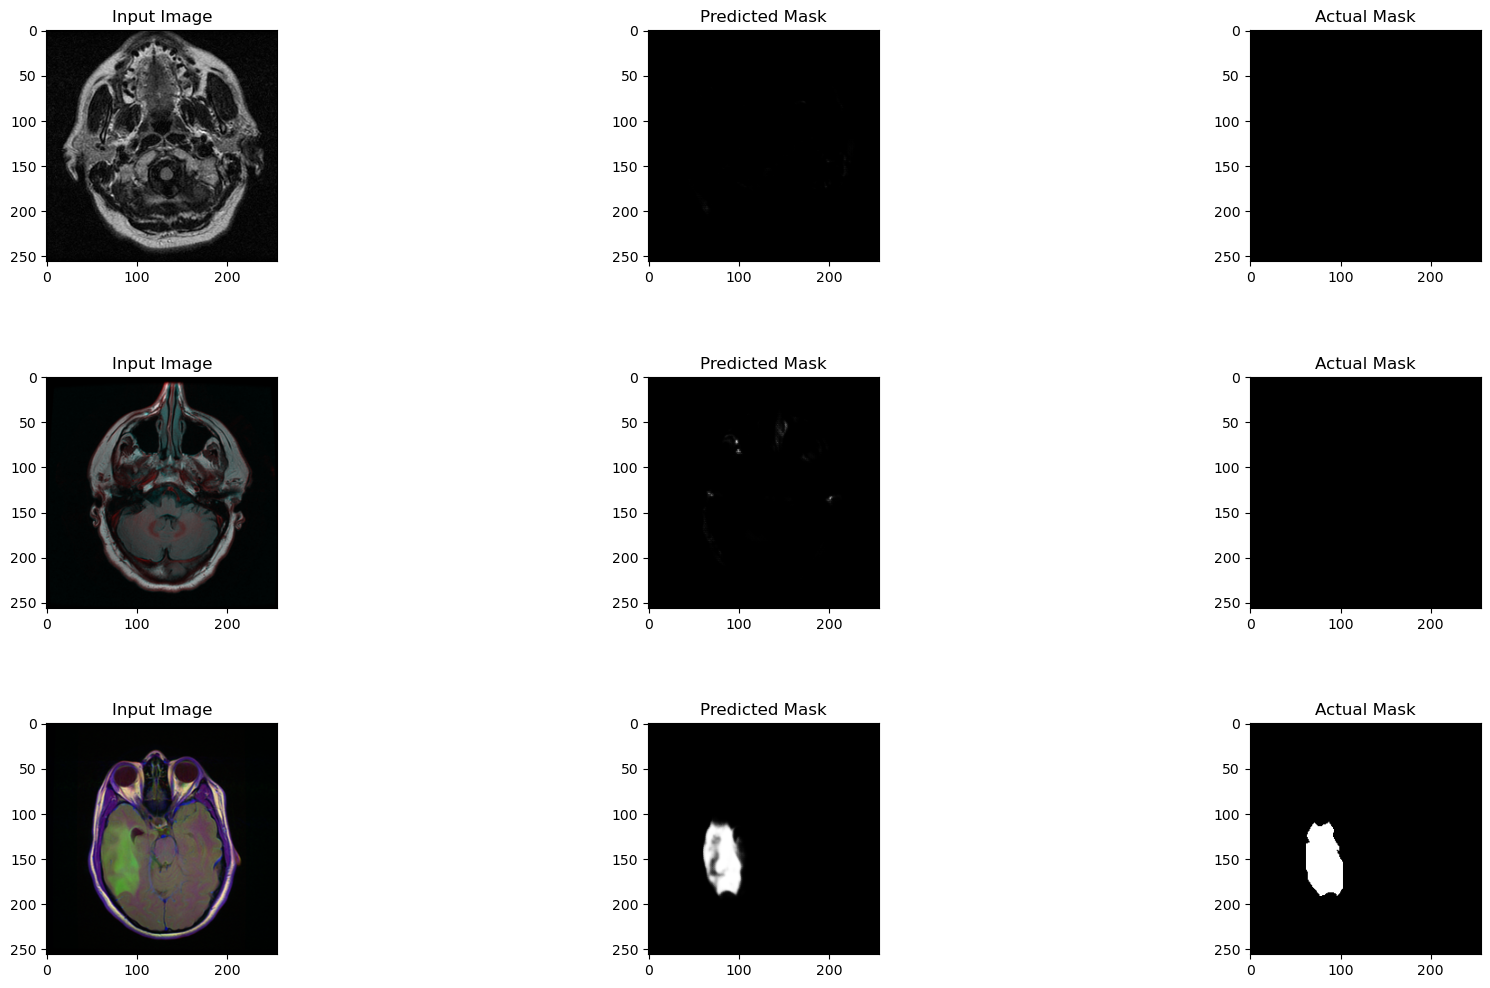

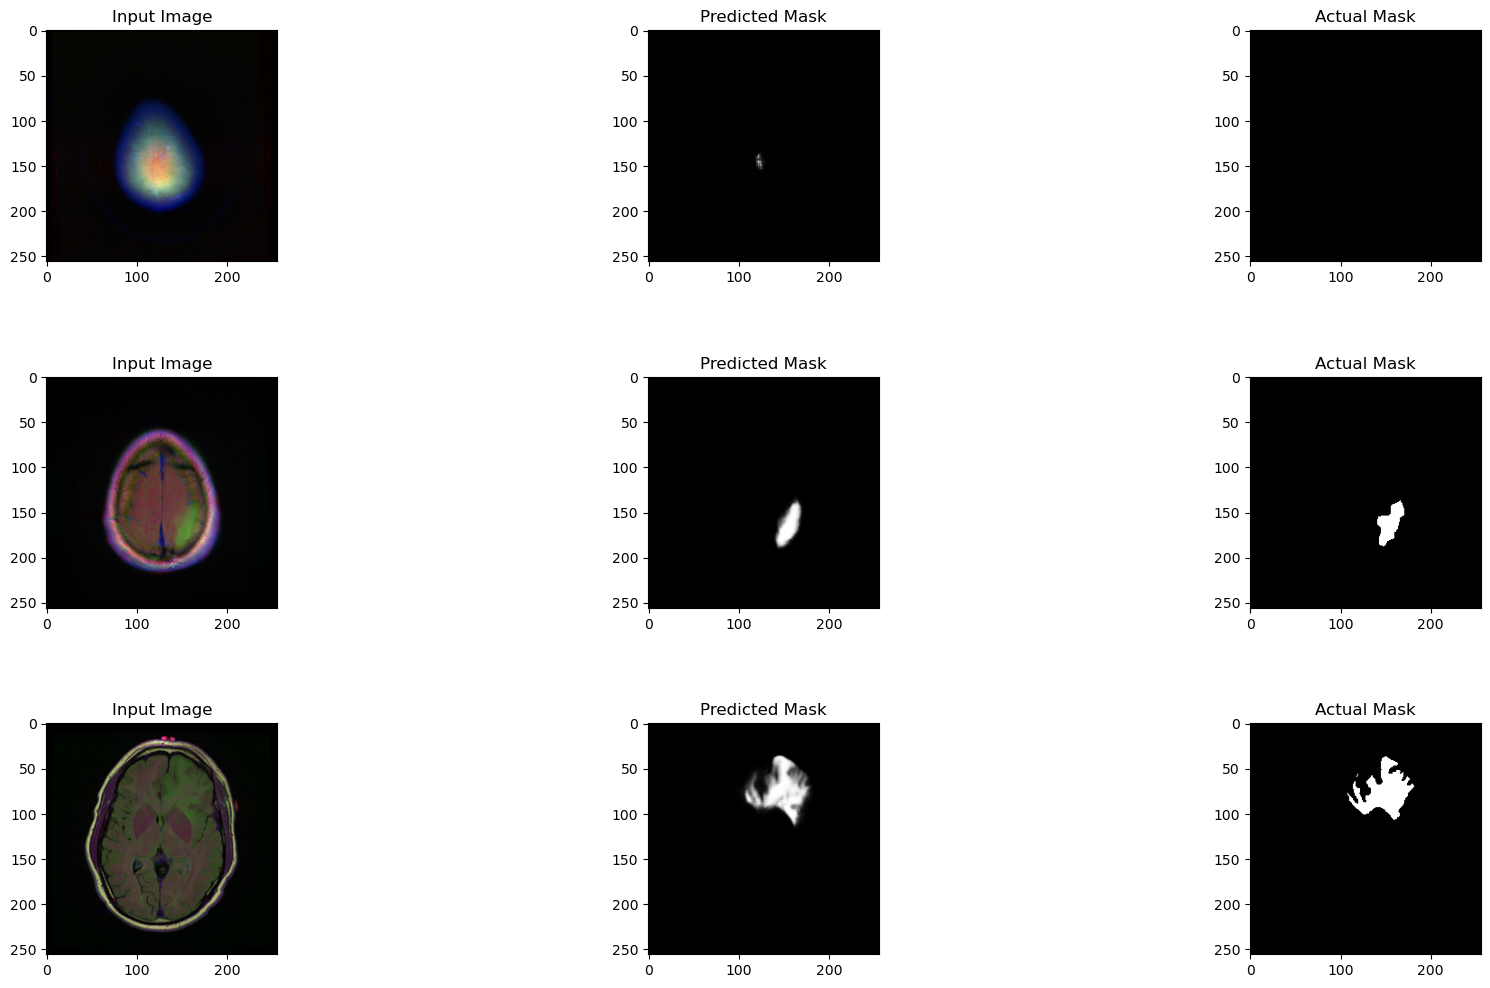

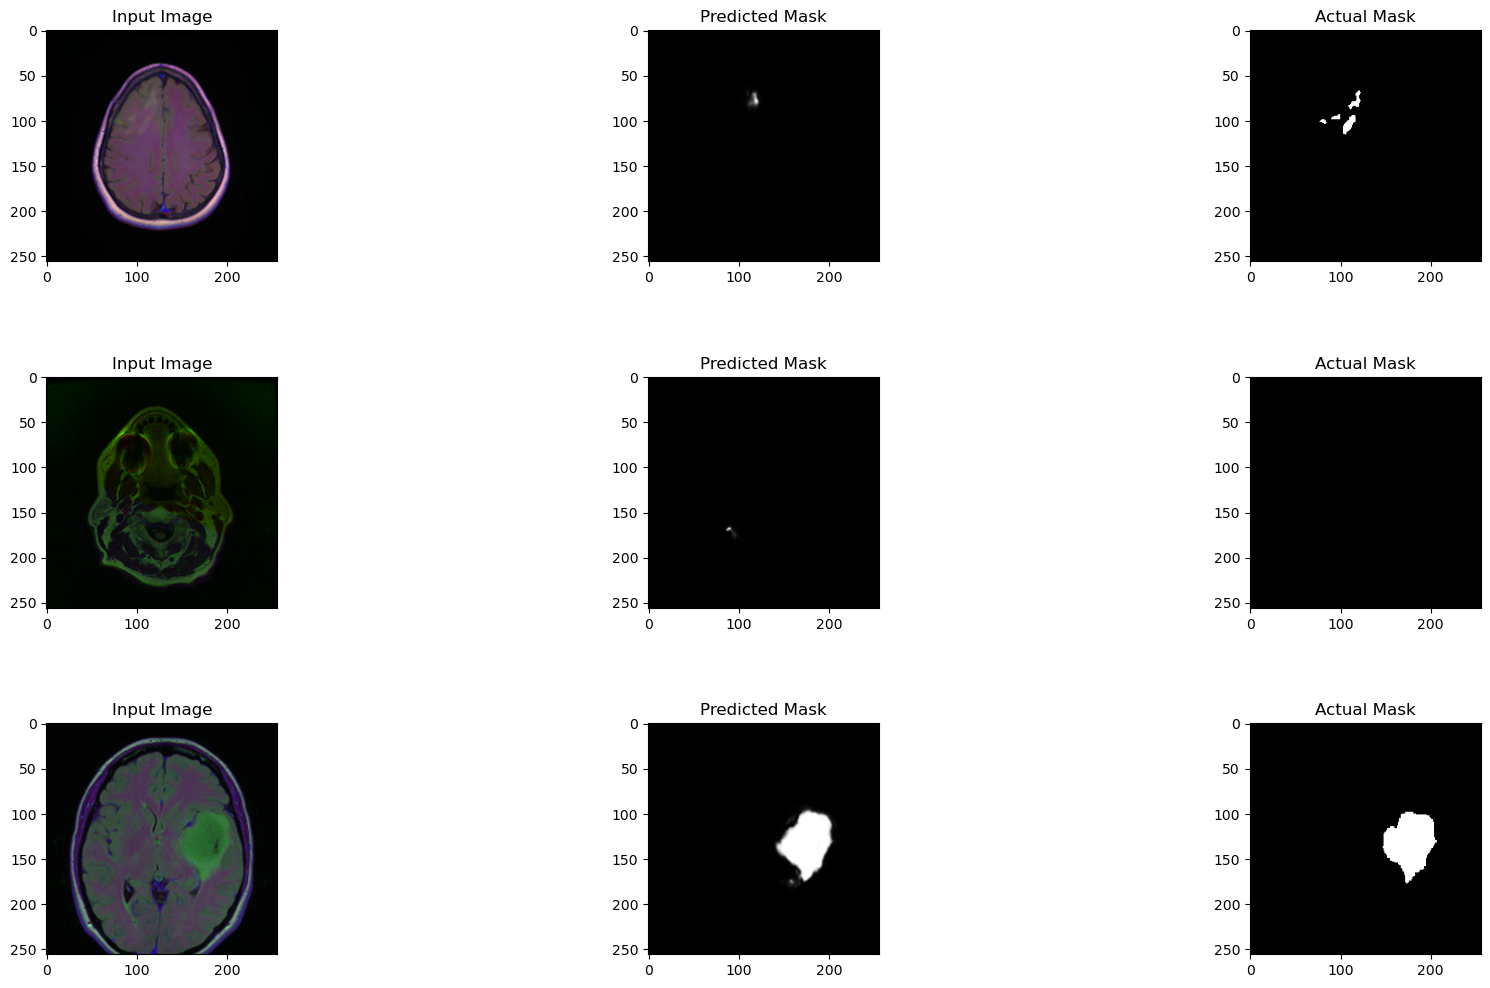

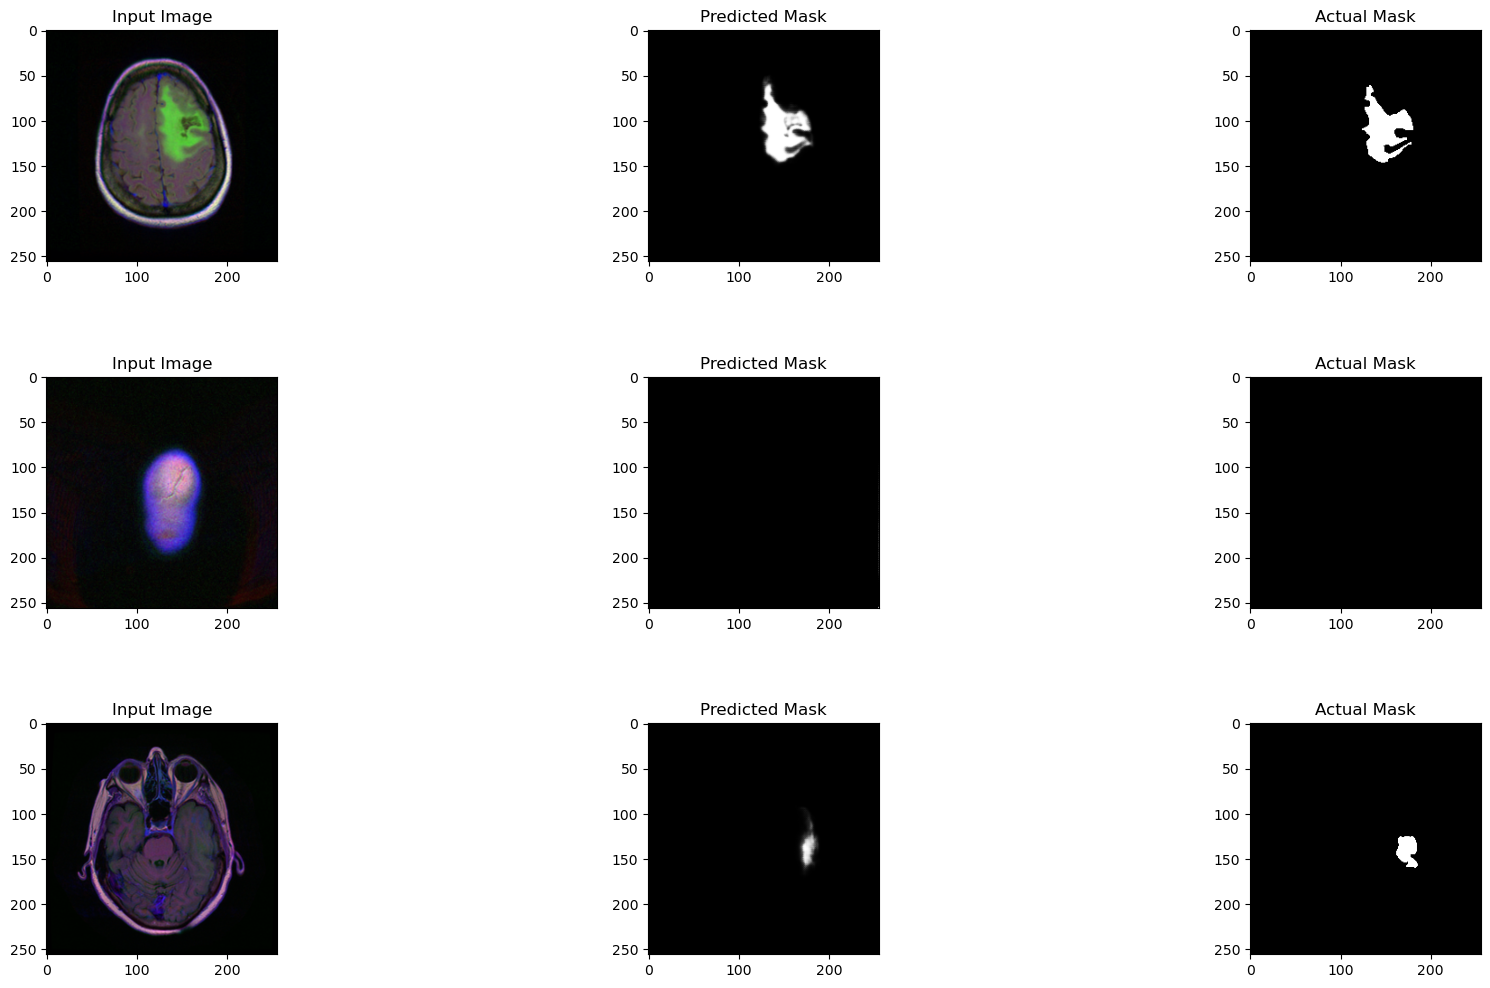

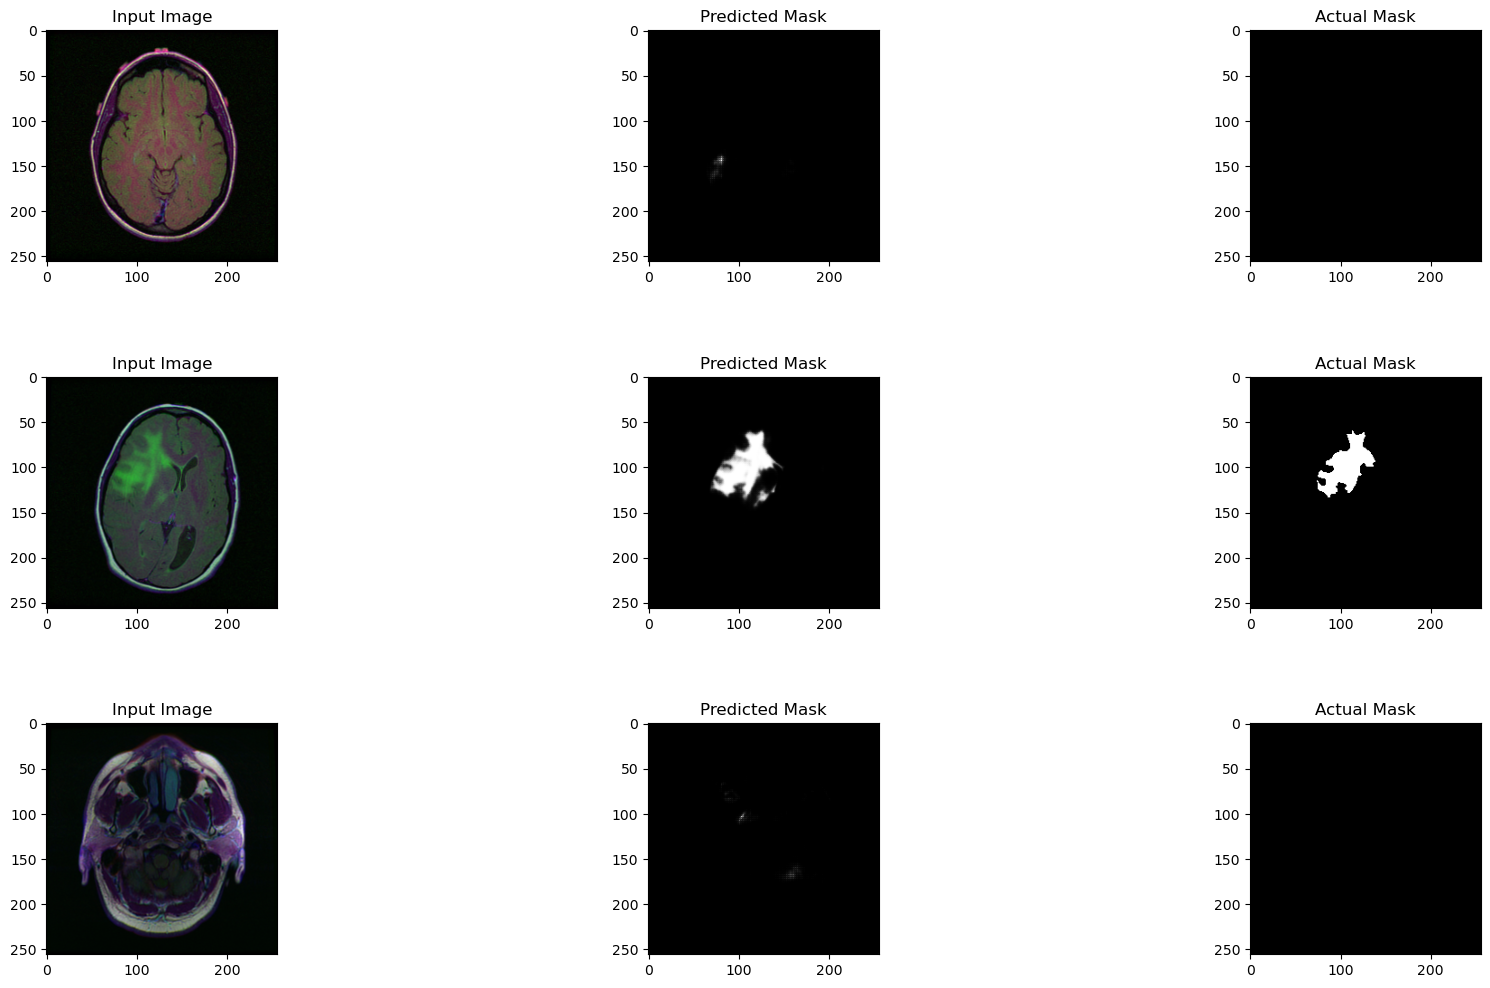

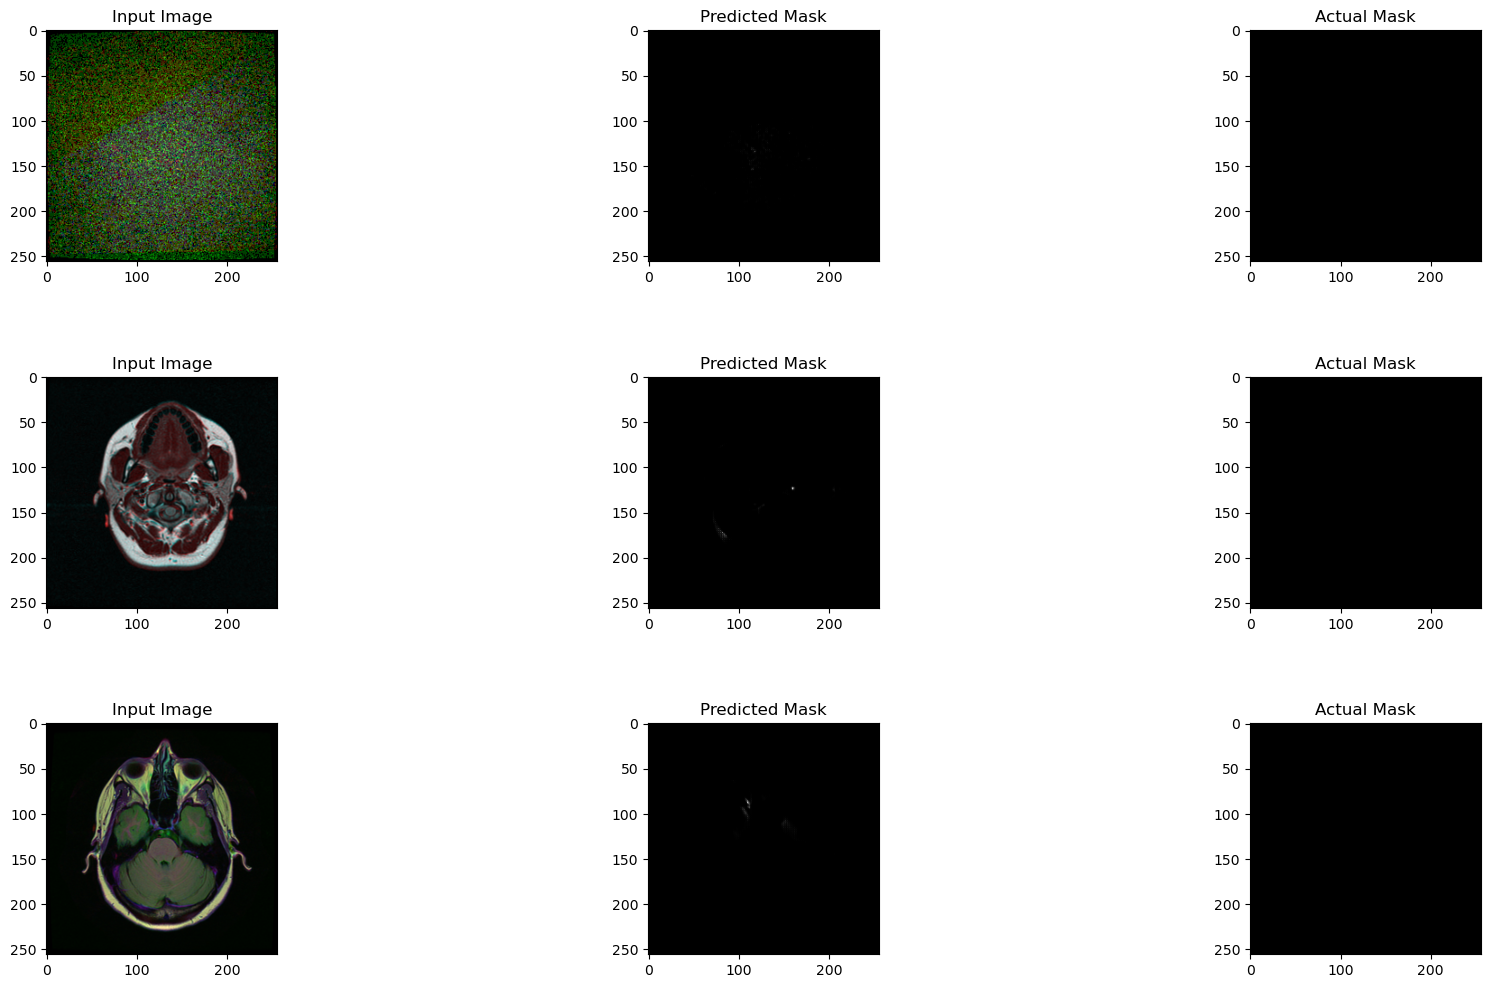

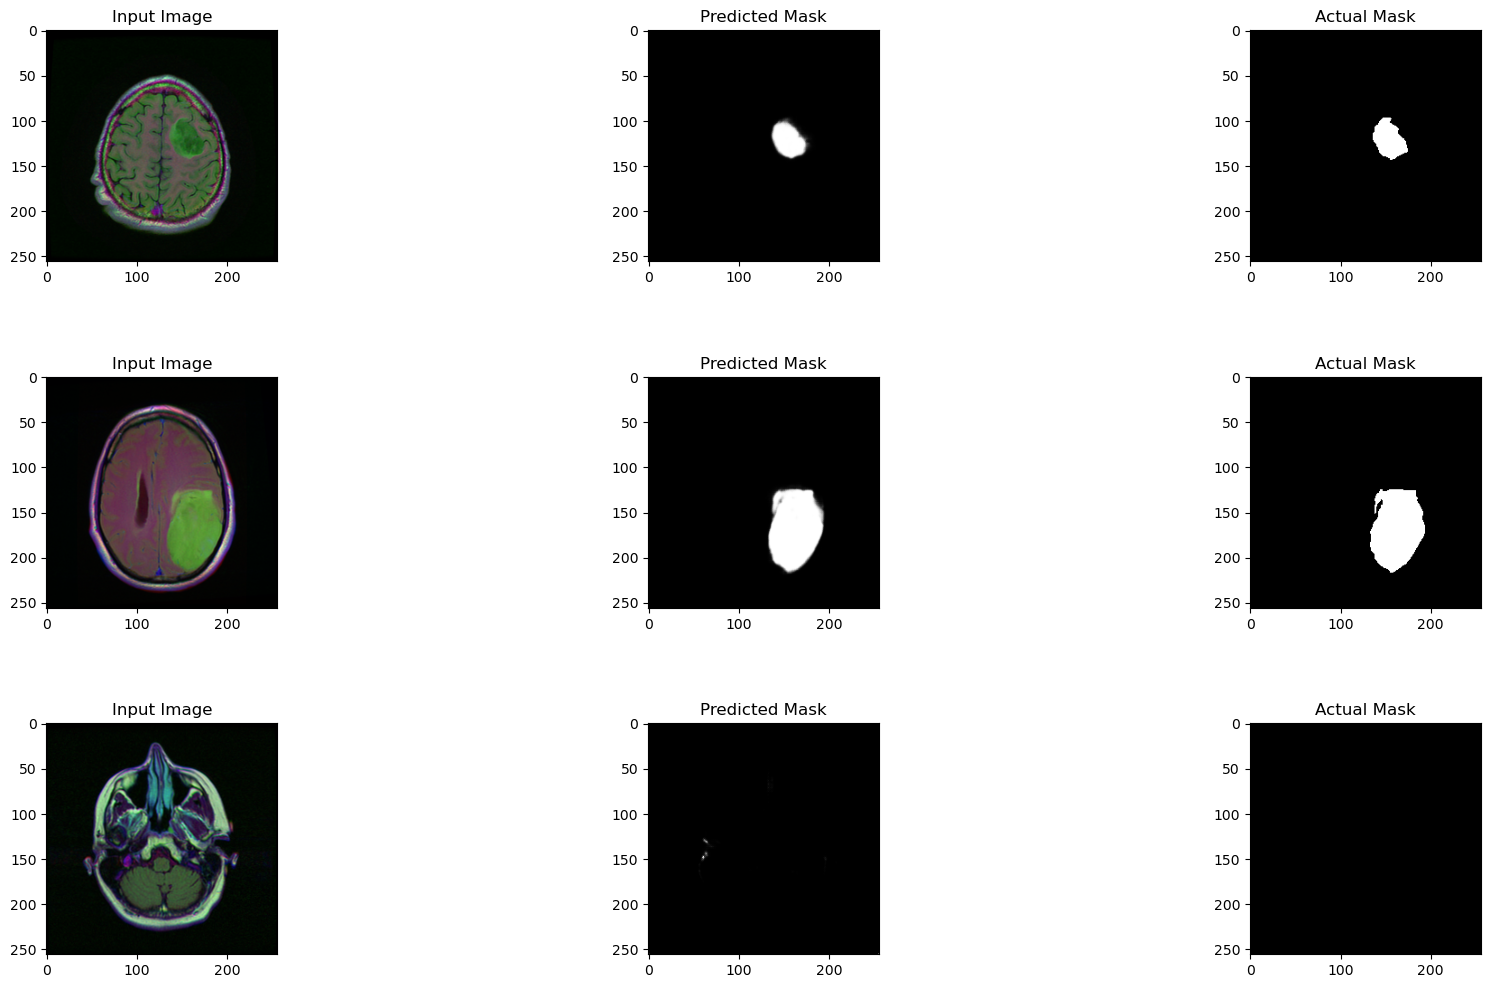

In [11]:
model = UNET(3,1,device=device).float().to(device)
final_path = 'final_model.pth'
checkpoint_path = 'latest_checkpoint.pth'

if os.path.exists(final_path):
     model.load_state_dict(torch.load(final_path))
elif os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])


dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=dev_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

evaluate(model, dataloader)

## Output the final accuracy scores

In [12]:
import torch

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    #print(dice)
    return dice


In [13]:
def eval_model(model, test_loader, device):
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)
            
            outputs[outputs < .5] = 0
            outputs[outputs > .5] = 1

            iou_score_val = iou_score(outputs, masks)
            dice_score_val = dice_score(outputs, masks)

            ious.append(iou_score_val)
            dices.append(dice_score_val)

    mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)

    return mean_iou, mean_dice

In [14]:
model.eval()
test_dataset = SegmentationDataset(test_df[test_df['Diagnosis'] == 1]['Image'].values.tolist(), test_df[test_df['Diagnosis'] == 1]['Mask'].values.tolist(), transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_model(model, test_dataloader, device)

(metatensor(0.8322, device='cuda:0'), metatensor(0.9083, device='cuda:0'))

## Model Visualization
This section visualizes the final model's training cycles based on its aggregated run and dev losses to produce a final output

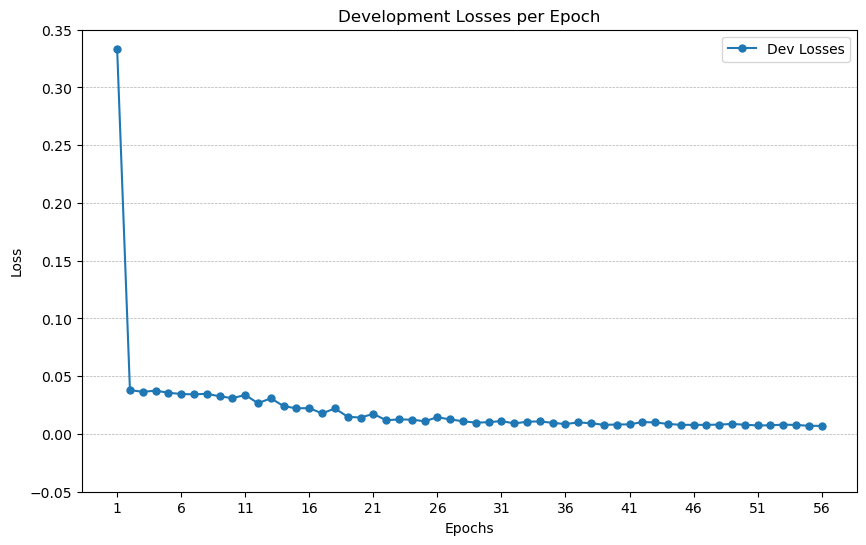

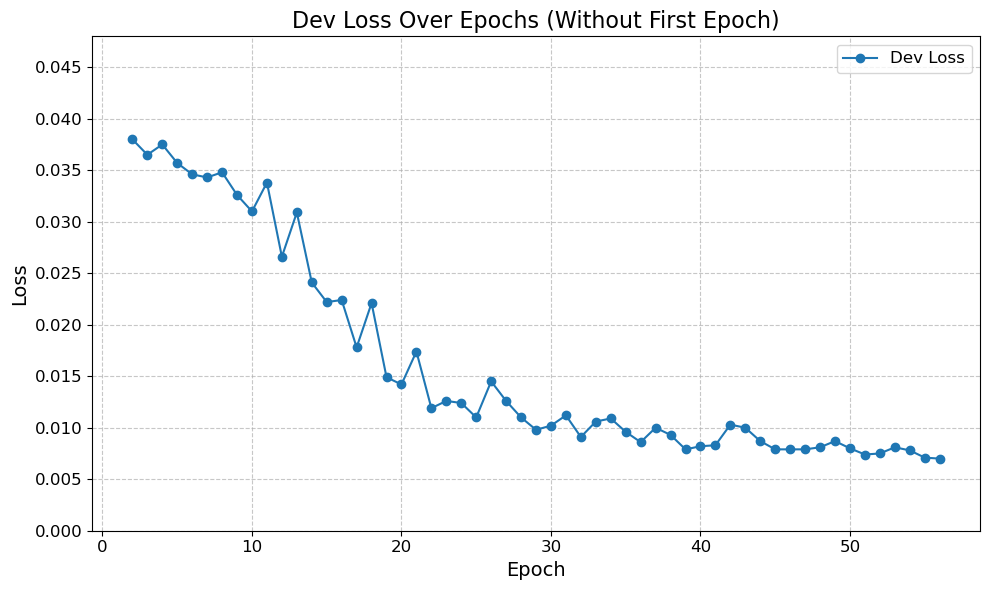

In [16]:
#Visualizes the dev/run losses of the final model
import matplotlib.pyplot as plt
run_losses = [
0.4741, 0.0439, 0.0328, 0.0323, 0.0319, 0.0313, 0.0308, 0.0306, 0.0297, 0.0286, 
0.0274, 0.0264, 0.0252, 0.0232, 0.0223, 0.0193, 0.0195, 0.0151, 0.0135, 0.0124, 
0.0119, 0.0119, 0.0097, 0.0103, 0.0087, 0.0089, 0.0099, 0.0081, 0.0074, 0.0071, 
0.0084, 0.0071, 0.0076, 0.0068, 0.0063, 0.0062, 0.0065, 0.0060, 0.0059, 0.0063,
0.0058, 0.0054, 0.0056, 0.0050, 0.0048, 0.0047, 0.0045, 0.0045, 0.0044, 0.0043,
0.0043, 0.0043, 0.0043 
]

dev_losses = [
    0.3336, 0.0380, 0.0365, 0.0375, 0.0357, 0.0346, 0.0343, 0.0348, 0.0326, 0.0310,
    0.0338, 0.0266, 0.0309, 0.0241, 0.0222, 0.0224, 0.0178, 0.0221, 0.0149, 0.0142,
    0.0174, 0.0119, 0.0126, 0.0124, 0.0110, 0.0145, 0.0126, 0.0110, 0.0098, 0.0102,
    0.0112, 0.0091, 0.0106, 0.0109, 0.0096, 0.0086, 0.0100, 0.0093, 0.0079, 0.0082,
    0.0083, 0.0103, 0.0100, 0.0087, 0.0079, 0.0079, 0.0079, 0.0081, 0.0087, 0.0080,
    0.0074, 0.0075, 0.0081, 0.0078, 0.0071, 0.0070
]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(dev_losses) + 1), dev_losses, marker='o', label='Dev Losses', linestyle='-', markersize=5)
plt.title('Development Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(dev_losses) + 1, 5))  
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend()

y_ticks = [round(x, 3) for x in plt.yticks()[0]]
plt.yticks(y_ticks)

plt.show()

filtered_dev_losses = dev_losses[1:]
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(dev_losses) + 1), filtered_dev_losses, marker='o', label='Dev Loss') 
plt.title('Dev Loss Over Epochs (Without First Epoch)', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.00, max(filtered_dev_losses) + 0.01) 
plt.yticks([i * 0.005 for i in range(0, int((max(filtered_dev_losses) + 0.01) / 0.005) + 1)])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'U-NET final.pth')

In [ ]:
model.load_state_dict(torch.load('U-NET final.pth'))

<All keys matched successfully>